# Installation des packages

# Préparation des données

In [1]:
from scripts import data_collector as dc
from scripts import data_cleaner as dcl
from scripts import data_analysis as da
from scripts import data_visualization as dv


landlocked_url = "https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline"
codesISO_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

# Codes ISO-2 et ISO-3 relatifs aux pays

In [2]:
codesISO_data = dc.get_ISOcodes(codesISO_url)
codesISO_data = dcl.clean_ISOData(codesISO_data)
codesISO_data

,Pays,ISO-2,ISO-3
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,Andorra,AD,AND
4,Angola,AO,AGO
...,...,...,...
188,Venezuela (Bolivarian Republic of),VE,VEN
189,Viet Nam[ak],VN,VNM
190,Yemen,YE,YEM
191,Zambia,ZM,ZMB


# PIB Réel

L'API permet de récupérer des données sur les pays via leurs codes ISO avec 2 lettres
Exemple : "FR" pour la France, "DE" pour l'Allemagne, "GB" pour le Royaume-Uni, etc.

In [3]:
wb = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-2"].tolist()
PIB_Reel_data = wb.get_indicator("PIB_reel", liste_pays, start=1990, end=2024)

#wb.plot("PIB_reel", title="Évolution du log(PIB réel) (2024 USD)")

# Valeurs manquantes

In [4]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

Le dataframe contient des données temporelles relatives à 193 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.


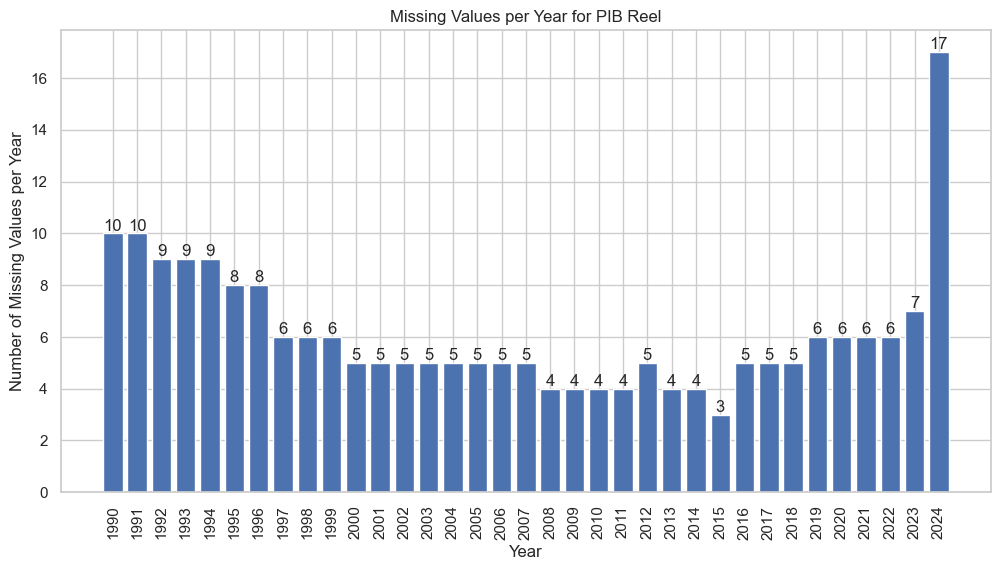

In [5]:
# Là on va checker d'où viennent les valeurs manquantes

# On va d'abord faire une analyse par date pour voir si c'est ça qui cause le problème

dv.plot_missing_values_per_year(PIB_Reel_data,"PIB")

In [6]:
# C'est bizarre qu'en 2024 il y ait plus de valeurs manquantes en 2024. Vérifions les pays dont les valeurs sont manquantes en 2024
NaN2024 = PIB_Reel_data[PIB_Reel_data["date"]==2024]["PIB"].isna()
NaN2024_countries = PIB_Reel_data[PIB_Reel_data["date"]==2024][NaN2024]
NaN2024_countries

# faire un commentaire
# Ce qu'on peut probablement faire c'est de l'imputation de données manquantes en utilisant la moyenne des valeurs des années précédentes pour chaque pays.
# Mais cela ne peut se faire que si on est dans des années qui sont intérieures c'est-à dire à partir de la première année omù il n'y a pas de valeur manquante

,country,date,PIB
0,Afghanistan,2024,NaN
910,Bhutan,2024,NaN
1435,Cuba,2024,NaN
1820,Eritrea,2024,NaN
3255,"Korea, Rep.",2024,NaN
3360,Lebanon,2024,NaN
3500,Liechtenstein,2024,NaN
3745,Monaco,2024,NaN
4830,Palau,2024,NaN
4935,"Korea, Dem. People's Rep.",2024,NaN


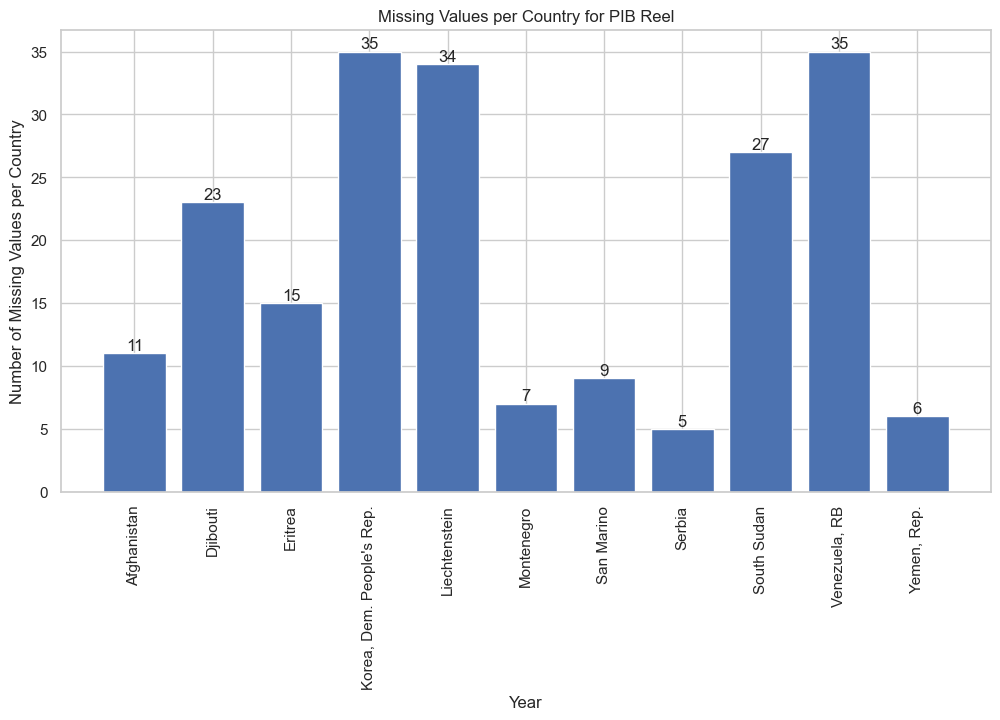

In [7]:
# Missing data per countries
# On va mettre un treshold à 5 valeurs pour tolérer 10% de données manquantes sinon on vire le pays.
countries_toRemove = dv.plot_missing_values_per_country(PIB_Reel_data,"PIB",treshold=0.1)

indexes_toRemove = []
for country in countries_toRemove:
    country_indexes = PIB_Reel_data[PIB_Reel_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

In [9]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

PIB_Reel_data_cleaned = PIB_Reel_data.drop(indexes_toRemove,axis='index')
PIB_Reel_data_cleaned.reset_index(drop=True,inplace=True)
da.check_missing_values(PIB_Reel_data_cleaned,"PIB")

Le dataframe contient des données temporelles relatives à 193 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 182 pays de 1990 à 2024.
Il y a 9 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.14% de valeurs manquantes dans la base de données.


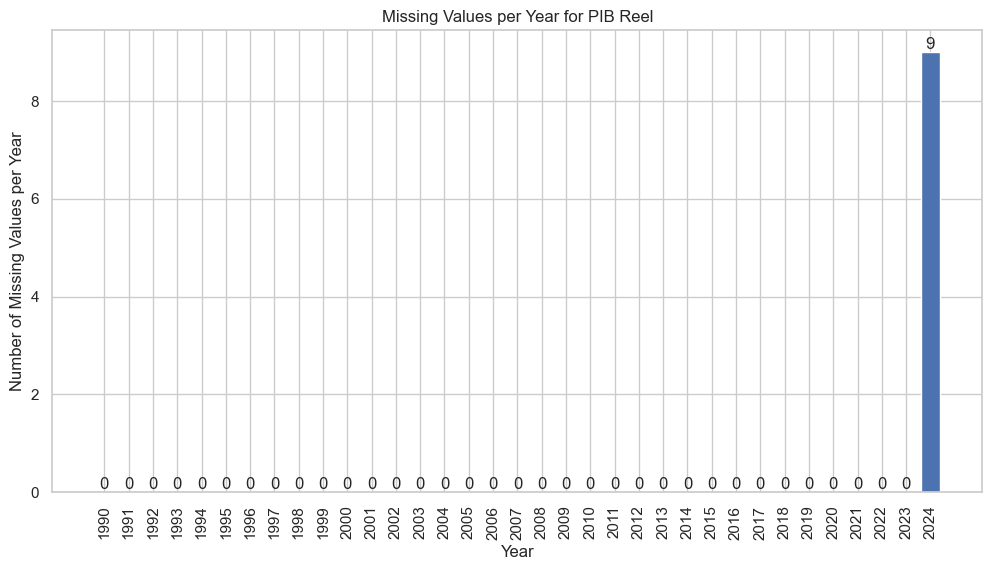

In [10]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(PIB_Reel_data_cleaned,"PIB")

In [ ]:
# La majeure partie des valeurs manquantes sont en 2024. On peut les imputer avec la moyenne des années précédentes.
PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
da.check_missing_values(PIB_Reel_data_final,"PIB")